# License Plate Recognition w/ OCR (Optical Character Recognition)

### 1. Image Processing

The output of the code below will show two images, one in grayscale and the other in binary.

(526, 507)


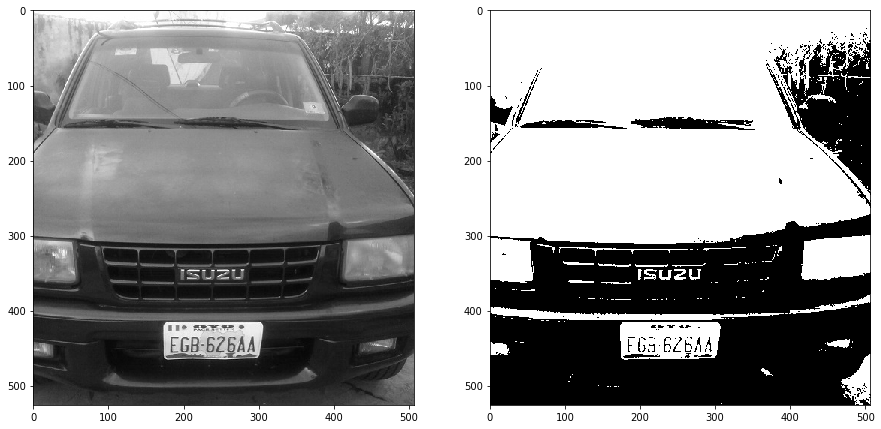

In [5]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

car_image = imread("car10.jpg", as_grey=True)
# it should be a 2 dimensional array
print(car_image.shape)

# the next line is not compulsory however, a grey scale pixel
# in skimage ranges between 0 & 1. multiplying it with 255
# will make it range between 0 & 255 (something we can relate better with

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
#print(threshold_value)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

### Connected Component Analysis (CCA)

CCA basically helps us group and label connected regions on the foreground. A pixel is deemed to be connected to another if they both have the same value and are adjacent to each other.

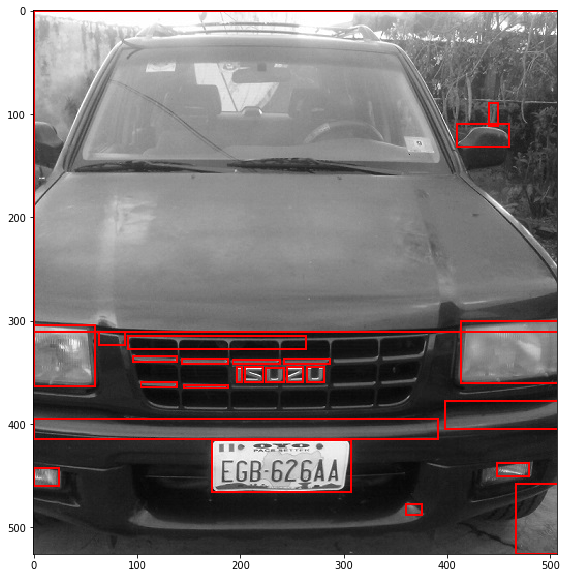

In [6]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)
#print(label_image)
fig, (ax1) = plt.subplots(1,figsize=(10,10))
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

From the resulting image, we can see that other regions that do not contain the license plate are also mapped. In order to eliminate these, we will use some characteristics of a typical license plate to remove them.
<br>1.They are rectangular in shape.
<br>2.The width is more than the height.
<br>3.The proportion of the width of the license plate region to the full image ranges between 15% and 40%.
<br>4.The proportion of the height of the license plate region to the full image is between 8% and 20%.

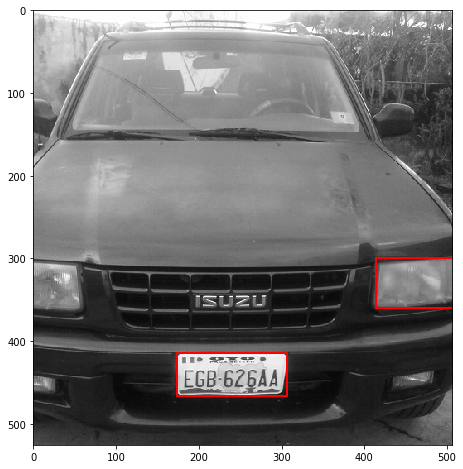

In [7]:
# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)

# getting the maximum width, height and minimum width and height that a license plate can be
plate_dimensions = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1,figsize=(8,8))
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue
    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

### Character Segmentation

/Users/ozgebozal/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


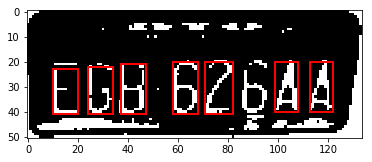

In [8]:
import numpy as np
from skimage.transform import resize

# The invert was done so as to convert the black pixel to white pixel and vice versa
license_plate = np.invert(plate_like_objects[1])

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
# the next two lines is based on the assumptions that the width of
# a license plate should be between 5% and 15% of the license plate,
# and height should be between 35% and 60%
# this will eliminate some
character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()